In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import sklearn
from sklearn.metrics.pairwise import haversine_distances
import csv
import keplergl
import scipy.stats
import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Placer.ai: Stop & Shop Analysis

![](ss.jpg)

How does the user's activity look like?

Analyze the user's activeness distribution (number of
active days) and present it.

User is defined as active on a given day if his coverage >= 0.75


For example, looking at the below record, we will count this day (7/1/2019) as active for this user as
coverage is >= 0.75
date device_id coverage
07/01/2019 1101 0.962326389

Note: you are not allowed to use Pandas/Dataframes in this question only (you CAN use
pandas in the rest of the assignment). You should use Python standard Data Structures
(lists/dictionaries etc.) to solve this part.

In [2]:
with open("hashed_users_activeness_2019-03-01_2019-09-01.csv", 'r') as filename:
    file = csv.DictReader(filename)
    date = []
    device_id = []
    coverage = []

    for col in file:
        device_id.append(col['device_id'])
        coverage.append(float(col['coverage']))
        caldate = col['\ufeffdate']               
        dd = str(caldate[0:2])
        mm = str(caldate[3:5])
        yyyy = str(caldate[6:])
        date.append(f"{mm}/{dd}/{yyyy}")

The first step is to open the file and populate lists for the data. The data is highly skewed, with the majority of coverage values being 1, some varied valued between 0 and 2

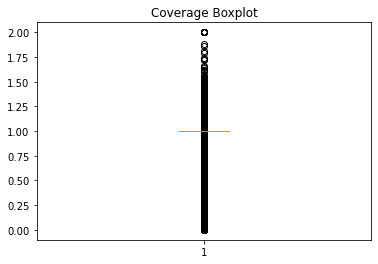

In [3]:
plt.boxplot(coverage)
plt.title("Coverage Boxplot")
plt.show()

As explained above, active users on a given are rows whose coverage is at least 0.75

In [4]:
active = [cov >= 0.75 for cov in coverage]
display(set(active))

{False, True}

The next step is to create useful dictionaries for aggregation, with the key being the date. From this we can take sums by date and see temporal trends

In [5]:
daily_coverage = {}
daily_active = {}
daily_count = {}

for d in range(len(date)):
    day = date[d]
    if day not in daily_coverage.keys():
        daily_coverage[day] = 0
    if day not in daily_active.keys():
        daily_active[day] = 0
    if day not in daily_count.keys():
        daily_count[day] = 0


    daily_coverage[day] += coverage[d]
    daily_active[day] += active[d]
    daily_count[day] += 1    

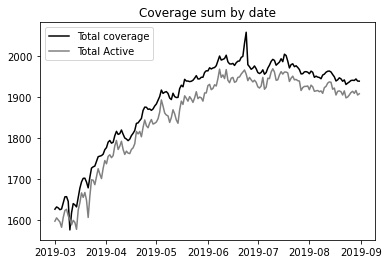

In [6]:
plt.plot(pd.to_datetime(list(daily_coverage.keys())), daily_coverage.values(), color = "black")
plt.plot(pd.to_datetime(list(daily_active.keys())), daily_active.values(), color = "grey")

plt.title("Coverage sum by date")
plt.legend(["Total coverage", "Total Active"])
plt.show()

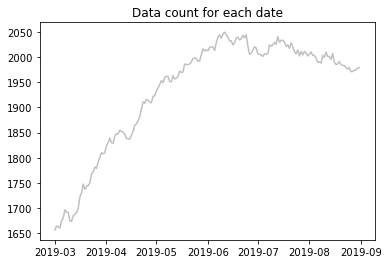

In [7]:
plt.plot(pd.to_datetime(list(daily_count.keys())), daily_count.values(), color = "silver")
plt.title("Data count for each date")
plt.show()

Though a trend is clear, it is simply the trend of the relative frequency of days. To fix this we will look at coverage and activity divided by how many times that date appears in the data

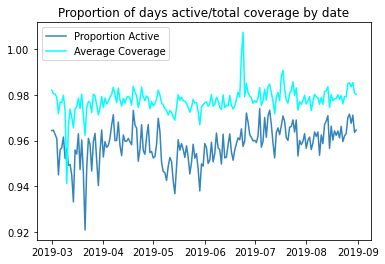

In [8]:
plt.plot(pd.to_datetime(list(daily_active.keys())), np.array(list(daily_active.values()))/np.array(list(daily_count.values())), alpha = 0.9)
plt.plot(pd.to_datetime(list(daily_coverage.keys())), np.array(list(daily_coverage.values()))/np.array(list(daily_count.values())), color = "cyan")

plt.title("Proportion of days active/total coverage by date")
plt.legend(["Proportion Active", "Average Coverage"])
plt.show()

This is starting to look like more of a time series with a baseline and seasonality, for which a model could be built. 

Note the anomalous peak with average daily coverage greater than 1: this is a due to rows that have a coverage value > 1, possibly an error, but the problem statement does not give enough information to make any assumptions

Now let's aggregate by user to see user trends and averages, once again populating dictionaries

In [9]:
user_coverage = {}
user_active = {}
user_count = {}

for d in range(len(device_id)):
    user = int(device_id[d])
    if user not in user_coverage.keys():
        user_coverage[user] = 0
    if user not in user_active.keys():
        user_active[user] = 0
    if user not in user_count.keys():
        user_count[user] = 0

    user_coverage[user] += coverage[d]
    user_active[user] += int(active[d])
    user_count[user] += 1 

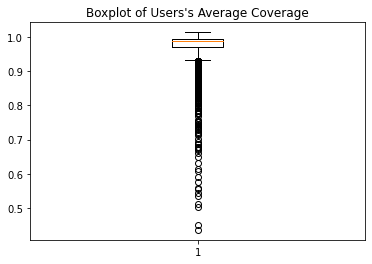

In [10]:
plt.boxplot(np.array(list(user_coverage.values()))/np.array(list(user_count.values())))
plt.title("Boxplot of Users's Average Coverage")
plt.show()

The user's average coverage distribution is skewed close to 1, with lower values being more rare

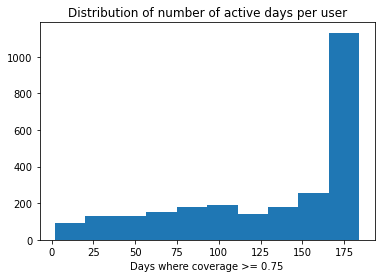

In [11]:
plt.hist(user_active.values())
plt.title("Distribution of number of active days per user")
plt.xlabel("Days where coverage >= 0.75")
plt.show()

As mentioned before, this view can be misleading since some users simply have more data entries total. Let's take a look at the user's proportion of days active

Mean proportion active per user: 0.9473537555906334


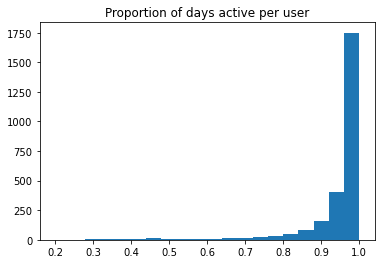

In [12]:
prop_active = np.array(list(user_active.values()))/np.array(list(user_count.values()))
print(f"Mean proportion active per user: {sum(prop_active)/len(prop_active)}")
plt.hist(prop_active, bins = 20)
plt.title("Proportion of days active per user")
plt.show()


Highly skewed, with a mean of 94.7% chance of a user's day being active

# Data input and basic visual breakdown

In [13]:
users = pd.read_csv("hashed_users_activeness_2019-03-01_2019-09-01.csv")
visits = pd.read_csv("hashed_visits_Stop_&_Shop_2335_Dixwell_Ave_Hamden_CT_United_States_2019-03-01_2019-09-01.csv")

In [14]:
users['active'] = 0
users.loc[users.coverage >= 0.75, "active"] = 1
users

,date,device_id,coverage,active
0,01/03/2019,1002,1.0,1
1,01/03/2019,1004,1.0,1
2,01/03/2019,1013,1.0,1
3,01/03/2019,1014,1.0,1
4,01/03/2019,1015,1.0,1
...,...,...,...,...
355770,31/08/2019,3584,1.0,1
355771,31/08/2019,3585,1.0,1
355772,31/08/2019,3586,1.0,1
355773,31/08/2019,3587,1.0,1


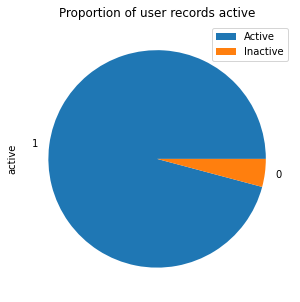

In [15]:
plt.figure(figsize=(5,5))
users.active.value_counts().plot.pie()
plt.title("Device Activeness")
plt.legend(["Active", "Inactive"], loc="best")
plt.title("Proportion of user records active")
plt.show()

In [16]:
visits.isnull().sum()

device_id           0
visit_id            0
venue_id            0
visit_start_time    0
visit_end_time      0
visit_lat           0
visit_long          0
visit_weight        0
user_home_lat       0
user_home_long      0
dtype: int64

In [17]:
visits.describe()

,device_id,visit_lat,visit_long,visit_weight,user_home_lat,user_home_long
count,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000
mean,2138.235596,41.372533,-72.914449,85.905893,41.262223,-73.149415
std,736.490686,0.000274,0.000292,29.823690,1.115540,2.302923
min,1000.000000,41.371635,-72.915543,19.627886,26.153133,-121.559890
25%,1493.000000,41.372330,-72.914642,59.725148,41.344350,-72.941525
50%,2075.000000,41.372566,-72.914436,87.450396,41.365456,-72.921507
75%,2739.000000,41.372734,-72.914276,99.552959,41.391703,-72.901074
max,3588.000000,41.373276,-72.913040,391.667556,47.038775,-68.543798


There are no null or missing values. Minimum and maximum values are all within reasonable range (we will investigate visit times in a minute)

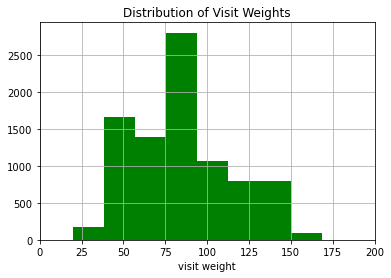

In [18]:
visits.visit_weight.hist(bins=20, color = "green")
plt.xlim(0,200)
plt.xlabel("visit weight")
plt.title("Distribution of Visit Weights")
plt.show()

Next we will convert visit times to datetime format and add a column for the total length of each visit in minutes

In [19]:
visits.visit_start_time = pd.to_datetime(visits.visit_start_time)
visits.visit_end_time = pd.to_datetime(visits.visit_end_time)
visits['visit_minutes'] = (visits.visit_end_time - visits.visit_start_time).dt.total_seconds()/60
visits

,device_id,visit_id,venue_id,visit_start_time,visit_end_time,visit_lat,visit_long,visit_weight,user_home_lat,user_home_long,visit_minutes
0,1019,5c79e42c0c503906e8b3b5d1,4ceb1df9727f7ce6265b814d,2019-01-03 07:57:00,2019-01-03 09:12:00,41.371765,-72.913490,108.285336,41.363650,-72.948267,75.0
1,1019,5c7b3395e9628006650a438c,4ceb1df9727f7ce6265b814d,2019-02-03 09:47:00,2019-02-03 10:17:00,41.372513,-72.914375,108.870449,41.362900,-72.949111,30.0
2,1019,5c898582cd70f1062a24c5ef,4ceb1df9727f7ce6265b814d,2019-12-03 11:12:00,2019-12-03 12:22:00,41.372467,-72.914421,103.192100,41.363473,-72.948513,70.0
3,1019,5c8a21ef2c03970605518c11,4ceb1df9727f7ce6265b814d,2019-03-13 10:17:00,2019-03-13 11:34:00,41.372490,-72.914337,100.045183,41.365061,-72.948657,77.0
4,1019,5c8b12b2e144fd064c87092f,4ceb1df9727f7ce6265b814d,2019-03-14 11:24:00,2019-03-14 13:29:00,41.372398,-72.914154,99.676487,41.363355,-72.949214,125.0
...,...,...,...,...,...,...,...,...,...,...,...
8760,1149,5d6bb5c6a1b81405717aa4b9,4ceb1df9727f7ce6265b814d,2019-08-31 19:18:00,2019-08-31 19:44:00,41.372902,-72.914368,99.627435,42.599821,-74.052362,26.0
8761,2424,5d6bb9529fef9e061bab2b64,4ceb1df9727f7ce6265b814d,2019-08-31 19:18:00,2019-08-31 19:43:00,41.372963,-72.914467,99.627435,42.600452,-74.052375,25.0
8762,2450,5d6ba1f0b74ad6058c117e30,4ceb1df9727f7ce6265b814d,2019-08-31 20:33:00,2019-08-31 21:00:00,41.372215,-72.914886,114.104665,41.313369,-72.940362,27.0
8763,1870,5d6bc9d28264b305ef196f23,4ceb1df9727f7ce6265b814d,2019-08-31 20:36:00,2019-08-31 20:56:00,41.372139,-72.914124,114.104665,41.315403,-72.940001,20.0


# Visitation Patterns

Visitation Patterns - Placer’s core metric is the foot-traffic estimation (i.e. estimated number of
visits). Analyze the visits and present the visitation patterns in the best way it represents the data
provided as you see it. 

Notes:

○ The graphs should include visits of active users only: visits where the associated user (i.e.
device_id) was active for more than 90 days during the entire period (using what you’ve
done in the first question!)

○ Use visit_weight to present any visits data. visit_weight is the extrapolated
value of the raw visit. The weight does not indicate the quality of the individual
customer but provides an extrapolation to the general population (as if we have
collected data for all of the people). So if you want to get to the estimated number of
visits to the location, you would sum on this field (as opposed to counting records).

In [20]:
# join data using pd.merge to get coverage, first create common joiner field that encapsulates device and date

users["joiner"] = users.device_id.astype(str) + "-" + pd.to_datetime(users.date).dt.date.astype(str)
visits["joiner"] = visits.device_id.astype(str) + "-" + visits.visit_start_time.dt.date.astype(str)

visits = visits.merge(users, on="joiner", how="left")
visits["device_id"] = visits.device_id_x
visits = visits.drop(["device_id_x", "device_id_y", "joiner"], axis=1)

print("Unique Users:")
print(len(users.device_id.unique()))   # 2589 different users

print("Active Users:")
print(sum(users.groupby("device_id").active.sum() > 90))   # 1928 active users

Unique Users:
2589
Active Users:
1928


In [21]:
active_devices = users.device_id.unique()[users.groupby("device_id").active.sum() > 90]
visits_active = visits[visits.device_id.isin(active_devices)]
visits_active['date'] = pd.to_datetime(visits_active['date'])
visits_active

,visit_id,venue_id,visit_start_time,visit_end_time,visit_lat,visit_long,visit_weight,user_home_lat,user_home_long,visit_minutes,date,coverage,active,device_id
93,5c7a119280cfa2068047dc95,4ceb1df9727f7ce6265b814d,2019-01-03 08:30:00,2019-01-03 09:16:00,41.372459,-72.914444,80.699429,41.415198,-72.939526,46.0,2019-01-03,1.0,1,1868
94,5c8f393065148e0666c4a241,4ceb1df9727f7ce6265b814d,2019-03-17 14:56:00,2019-03-17 15:28:00,41.372612,-72.914215,65.415739,41.416281,-72.938965,32.0,2019-03-17,1.0,1,1868
95,5d17b5ef478ac0060453305b,4ceb1df9727f7ce6265b814d,2019-06-28 22:19:00,2019-06-28 22:39:00,41.372658,-72.914368,99.888767,41.416957,-72.938955,20.0,2019-06-28,1.0,1,1868
96,5d2b30340f090805d6449fad,4ceb1df9727f7ce6265b814d,2019-07-13 14:34:00,2019-07-13 14:58:00,41.372658,-72.914230,99.924237,41.416761,-72.936806,24.0,2019-07-13,1.0,1,1868
97,5d331a9666ac2805f7e3ed9f,4ceb1df9727f7ce6265b814d,2019-07-19 16:37:00,2019-07-19 17:05:00,41.372368,-72.914772,102.024059,41.416107,-72.937609,28.0,2019-07-19,1.0,1,1868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8757,5d6b595a295be105e789c1d7,4ceb1df9727f7ce6265b814d,2019-08-31 14:08:00,2019-08-31 14:26:00,41.372375,-72.914162,63.873399,43.314187,-76.390449,18.0,2019-08-31,1.0,1,2790
8760,5d6bb5c6a1b81405717aa4b9,4ceb1df9727f7ce6265b814d,2019-08-31 19:18:00,2019-08-31 19:44:00,41.372902,-72.914368,99.627435,42.599821,-74.052362,26.0,2019-08-31,1.0,1,1149
8761,5d6bb9529fef9e061bab2b64,4ceb1df9727f7ce6265b814d,2019-08-31 19:18:00,2019-08-31 19:43:00,41.372963,-72.914467,99.627435,42.600452,-74.052375,25.0,2019-08-31,1.0,1,2424
8762,5d6ba1f0b74ad6058c117e30,4ceb1df9727f7ce6265b814d,2019-08-31 20:33:00,2019-08-31 21:00:00,41.372215,-72.914886,114.104665,41.313369,-72.940362,27.0,2019-08-31,1.0,1,2450


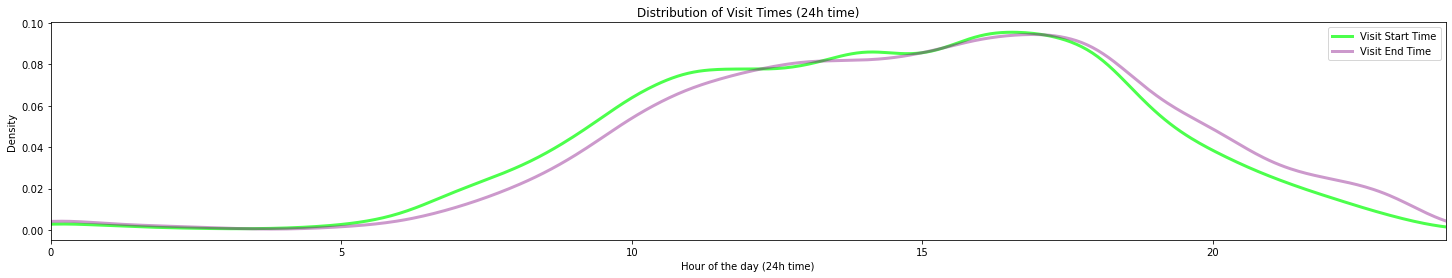

In [22]:
plt.figure(figsize=(25,4))
pd.to_datetime(visits_active.visit_start_time).dt.hour.plot.kde(color = "lime", linewidth=3, alpha = 0.7)
pd.to_datetime(visits_active.visit_end_time).dt.hour.plot.kde(color = "purple", linewidth=3, alpha = 0.4)
plt.legend(["Visit Start Time", "Visit End Time"])
plt.title("Distribution of Visit Times (24h time)")
plt.xlabel("Hour of the day (24h time)")
plt.xlim(0, 24)
plt.show()

Predictably, end times are distributed like start times but shifted right. Visits to Stop & Shop are most popular at around 5pm and drop down from there, with noon to 5 being peak hours. 

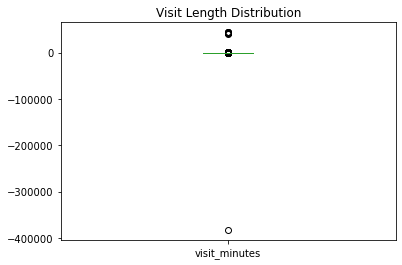

In [23]:
visits_active.visit_minutes.plot(kind="box")
plt.title("Visit Length Distribution")
plt.show()

The distribution of the length of a visit is highly skewed and is more comprehensible on a boxplot than a histogram 

One visit has the start time after the end time, and 60 visits are longer than 5 hours, often much longer, which is suspicious. Removing these rows would create a gap in the time series and is inadvisable. Instead, we will clip the visit length to 5 hours (an estimate of the most time anyone would reasonably visit a supermarket) and adjust the end time accordingly. For the row with negative visit length we will replace the visit length with the lowest visit length above 0

In [24]:
sum(visits_active.visit_minutes > 300)

60

In [25]:
visits_active[(visits_active.visit_start_time > visits_active.visit_end_time)]

,visit_id,venue_id,visit_start_time,visit_end_time,visit_lat,visit_long,visit_weight,user_home_lat,user_home_long,visit_minutes,date,coverage,active,device_id
2344,5c89e53601646c05cb44ef4c,4ceb1df9727f7ce6265b814d,2019-12-03 22:11:00,2019-03-13 02:42:00,41.372047,-72.915062,60.817403,41.386014,-72.869652,-382769.0,2019-12-03,1.0,1,2060


In [26]:
visits_active.loc[visits_active.visit_minutes > 300, "visit_end_time"] += pd.Timedelta(hours=10)
visits_active.loc[visits_active.visit_minutes > 300, "visit_minutes"] = 300

lowest = visits_active.visit_minutes.sort_values()[1:2]
replacement = visits_active.loc[visits_active.visit_start_time > visits_active.visit_end_time, "visit_start_time"] + pd.Timedelta(hours=float(lowest)/60)
visits_active.loc[visits_active.visit_start_time > visits_active.visit_end_time, "visit_minutes"] = float(lowest)
visits_active.loc[visits_active.visit_start_time > visits_active.visit_end_time, "visit_end_time"] = replacement


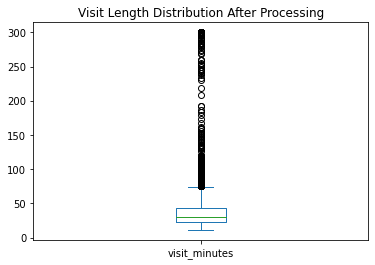

In [27]:
visits_active.visit_minutes.plot(kind="box")
plt.title("Visit Length Distribution After Processing")
plt.show()

Skewed, but much better

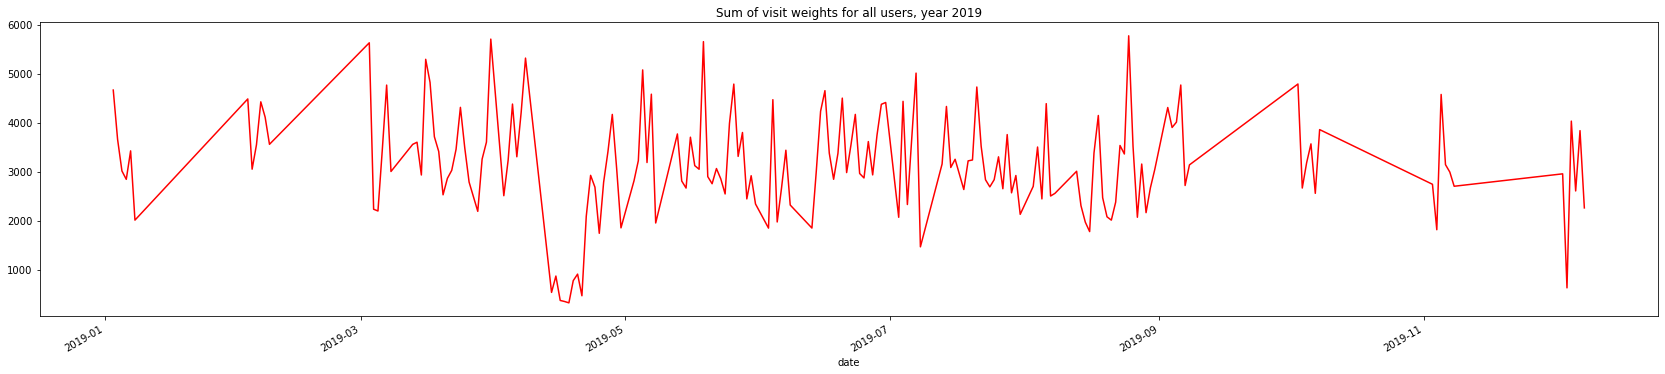

In [28]:
plt.figure(figsize=(29,6))
visits_active.groupby("date").visit_weight.sum().plot(color = "red")
plt.title("Sum of visit weights for all users, year 2019")
plt.show()

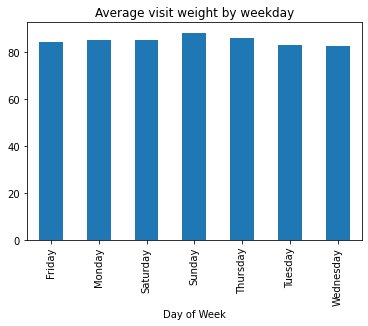

In [29]:
visits_active["weekday"] = visits_active.date.dt.day_name()
visits_active.groupby("weekday").visit_weight.mean().plot.bar()
plt.xlabel("Day of Week")
plt.title("Average visit weight by weekday")
plt.show()

There is no glaring difference in average visit weight between days of the week

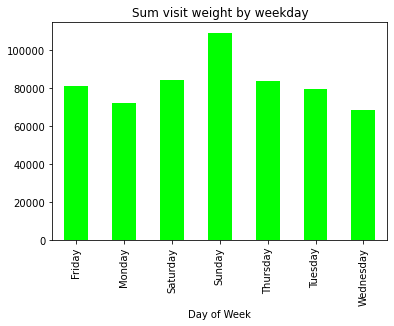

In [30]:
visits_active.groupby("weekday").visit_weight.sum().plot.bar(color = "lime")
plt.xlabel("Day of Week")
plt.title("Sum visit weight by weekday")
plt.show()

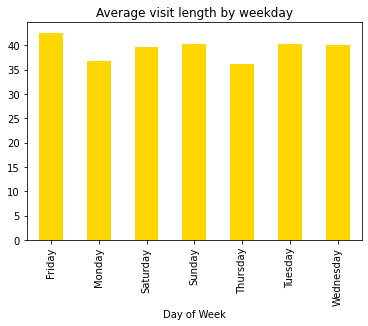

In [31]:
visits_active.groupby("weekday").visit_minutes.mean().plot.bar(color = "gold")
plt.xlabel("Day of Week")
plt.title("Average visit length by weekday")
plt.show()

However, based on total visit weight and total visits, it seems that Sundays are busiest. Customers also spend more time at Stop&Shop during Friday visits, and less time when arriving at 10pm. Late night arrivals are higher variance and less trustworthy since the sample size is so much smaller

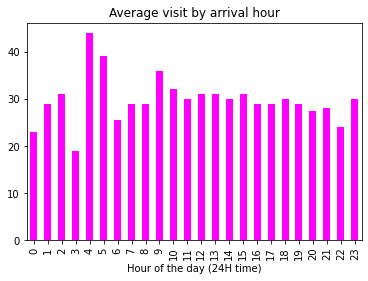

In [32]:
visits_active["start_hour"] = visits_active.visit_start_time.dt.hour
visits_active.groupby("start_hour").visit_minutes.median().plot.bar(color="magenta")
plt.xlabel("Hour of the day (24H time)")
plt.title("Average visit by arrival hour")
plt.show()

# Loyal Customers

How to define a ‘Loyal Customer’?

○ Analyze the distance of the customer's home location to the venue (think what is the best
way to present this data)

○ How would you define a ‘loyal customer’? 

Think of thresholds that make a customer loyal
(for example: visits frequency, distance from home or any other feature). Explain why you
chose this threshold and present the loyal/casual customers breakdown



We could get the distances by simply doing the distance formula, but this cartesian line is inaccurate due to the curvature of the earth's surface. The Haversine formula is a much more accurate approximation

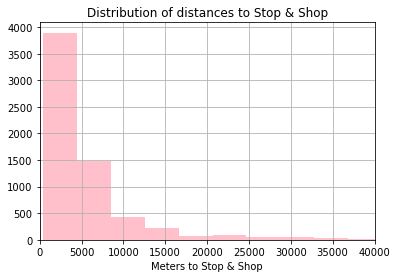

In [33]:
earth_radius = 6371000  

visits_active['distance'] = (haversine_distances(
        X=visits_active[['visit_lat','visit_long']].to_numpy()*np.pi/180, 
        Y=visits_active[['user_home_lat','user_home_long']].to_numpy()*np.pi/180)*earth_radius)[0]

# make a hist of distance column

visits_active.distance.hist(bins=1000, color="pink")
plt.xlim(0,40000)
plt.title("Distribution of distances to Stop & Shop")
plt.xlabel("Meters to Stop & Shop")
plt.show()

There is a huge range of varied values for distances, as we will see later. There are even points on the West Coast. Despite the established quality of Stop&Shop groceries, it's unlikely that someone would fly from Los Angeles to shop there!

Visit weight and distance are negatively correlated, which may mean distance alone isn't the best way to determine loyal customers

In [34]:
corr = visits_active[["visit_minutes", "distance", "visit_weight"]].corr()
corr.style.background_gradient(cmap='coolwarm_r')

,visit_minutes,distance,visit_weight
visit_minutes,1.000000,-0.014036,0.001517
distance,-0.014036,1.000000,-0.121934
visit_weight,0.001517,-0.121934,1.000000


In order to determine what makes a loyal customer, let's first take a look at customers that spend a lot of time at the store. Customers that spend a lot of time in the store are usually the ones purchasing the most.

This roughly follows an exponential distribution, which is commonly used in statistics to measure the amount of time until something happens. In our example, that is the time until the customer leaves the store. Notice the "tail end" of customers who don't behave normally, these are worth investigating

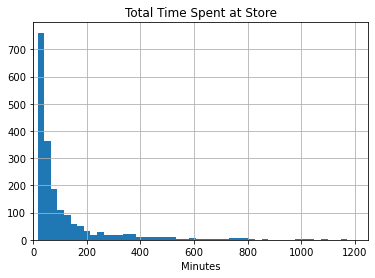

In [35]:
total_time_at_store = visits_active.groupby("device_id").visit_minutes.sum()
high_total_time_customers = list(total_time_at_store[total_time_at_store > 200].index)  # save device_id
total_time_at_store.hist(bins=1000)
plt.xlim(0,1250)
plt.xlabel("Minutes")
plt.title("Total Time Spent at Store")
plt.show()

Next let's look at customers that have traveled the most total distance to the store. It logically follows that if a customer is willing and has traveled a large total distance to the store, they are loyal. Individual trips can vary greatly, but a large total distance traveled is indicative. Notice a "long tail" of customers that have traveled greater than ~40km to get to Stop&Shop. The patterns of these customers are worth looking into.

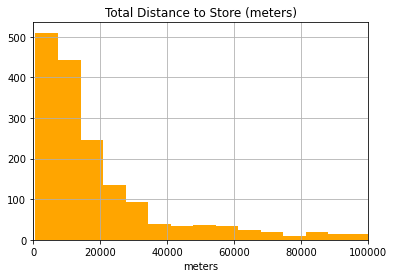

In [36]:
total_dist_to_store = visits_active.groupby("device_id").distance.sum()
high_distance_total_customers = list(total_dist_to_store[total_dist_to_store > 50000].index)  # save device_id
total_dist_to_store.hist(bins=2000, color = "orange")
plt.title("Total Distance to Store (meters)")
plt.xlabel("meters")
plt.xlim(0,100000)
plt.show()

Something interesting to note: The home coordinates for each device are not the same every time and vary considerably. This feature may represent something interesting that hasn't yet been explained in the presentation- this could be the user making multiple trips from multiple different locations. In that case, a good way to assess customer loyalty is to ask "Is the customer making trips to the store from many different locations, far and close?"

After all, distant trips are low weight and high variance, and could mean one-time necessities; it is unknown if a customer coming from far has another closer, preferred store in mind. But if customer chooses to visit Stop&Shop from very different starting points, it means that they likely prefer shopping there no matter where they are.

Below are customers divided by the range of trip distances. Notice the two groups, the low values and the tail. The phenomena of the customers in the tail are worth looking into. 

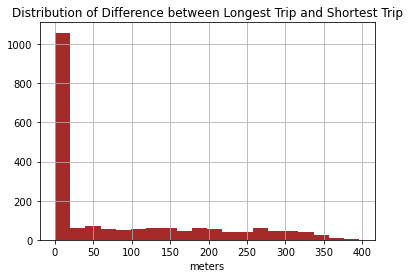

In [37]:
spread = visits_active.groupby("device_id").distance.max() - visits_active.groupby("device_id").distance.min()
high_distance_spread_customers = list(spread[spread > 200].index)  # save device_id
spread.hist(bins=20, color = "brown")
plt.title("Distribution of Difference between Longest Trip and Shortest Trip")
plt.xlabel("meters")
plt.show()

We have created three clusters based on these criteria: Time spent at store, time spent traveling to store, and variety in distances traveled to store.

Predictably, these often tend to be the same customers, so once we take the customers in common we get 91 of the most "Loyal" customers (out of 1928, the top 5%). Together, they account for 1803 out of the 6793 active visits (27%).

In [38]:
print("Cluster sizes:")
print(len(high_total_time_customers), len(high_distance_total_customers), len(high_distance_spread_customers))

loyal_set = set.intersection(set(high_total_time_customers), set(high_distance_total_customers))
loyal_set = list(set.intersection(loyal_set, set(high_distance_spread_customers)))
loyal = visits_active[visits_active.device_id.isin(loyal_set)]

print("Total unique customers in all sets:")
print(len(loyal_set))
print("Total visits by these customers:")
print(len(loyal))

Cluster sizes:
293 407 355
Total unique customers in all sets:
91
Total visits by these customers:
1803


# Geospatial Analysis

○ Bonus - Using Kepler.gl generate 2 heatmaps:

a. Customers home location

b. Only loyal customers home location

➢ Make sure you include a pin for venue location as well

Tip: You will need to calculate additional columns such as ‘Home distance from Stop & Shop.
Use the following coordinates as Stop & Shop’s location: 41.3723654,-72.9141964

By uploading the data to GIS software, we get a clear visual picture of the segmentation of loyal customers

![](stopshop.png)

Interestingly, the loyal customers (purple points) tend to cluster together fairly well in small neighborhoods and subdivisions. Analysing multiple attributes had the positive effect of removing high variance/long distance visits, such as the few odd ones coming all the way from Los Angeles.

![](stopshop2.png)

Although I am most comfortable with GIS software for mapping, let's create the same kind of map using Kepler since that is what was stated in the prompt

In [39]:
visits_active['store_lat'] = 41.3723654
visits_active['store_long'] = -72.9141964
loyal['store_lat'] = 41.3723654
loyal['store_long'] = -72.9141964


In [40]:
from keplergl import KeplerGl 
map_1 = KeplerGl(height=500)
map_2 = KeplerGl(height=400, data={"data_1": visits_active.iloc[:, 4:5]})
display(map_2)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


A Jupyter Widget

![](3dmap.png)

For this kind of project, Kepler proves to be useful and aesthetically more pleasing to look at, though I was not able to get the package and widgets installed to make it visible natively on Jupyter Notebook. The 3D map shows clusters of loyal customers arcing to the location of Stop&Shop

A further demographic and analysis would be valuable to Stop&Shop from a business perspective. If given more time and a salaried role, I would download layers of US Census data, land use shapefiles from the New Haven county website, building records from Zillow, and nearby POI to get a sense of access to competitors. I have done this workflow before as part of a suitability analysis for a new construction site

# Thank you for the opportunity!

-Ben Hendel